In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
%cd /content/drive/My\ Drive/Winter\ 2022/CME241

Mounted at /content/drive
/content/drive/My Drive/Winter 2022/CME241


In [2]:
from rl.distribution import *
from rl.markov_process import *

#1. Snakes and Ladders

##Constructing the Transition Matrix


(I somehow cannot put the image of the board in this notebook, but it can be found within the folder)

Overall, it can be summarized as
1.) 

1.   Start at 0
2.   End at 100 (being a terminal state)
3.   Each dice turn (perhaps) choose the number of steps to be uniformly random from 1 to 6. (There is some bonus dice toss, but we will count it as an extra turn for simplicity)
4.   If the player hit 100 with steps left, the player will bounce off.
5.   Instant moves in the following pairs:
- 1 to 38
- 4 to 14
- 9 to 31
- 16 to 6
- 21 to 42
- 36 to 44
- 47 to 26
- 49 to 11
- 51 to 67
- 56 to 53
- 62 to 19
- 64 to 60
- 71 to 91
- 80 to 100
- 93 to 73
- 95 to 75
- 98 to 78

Without the condition 5. (which is the existence of the ladders and snakes), we can easily see that the game is a markov process since the increment from the current state is always uniformly at random from $\{1, 2, 3, 4, 5, 6\}$ (independent from path). The states can be modelled as 0, 1, 2, 3, $\dots$ ,100. Thus, we have a total of 101 states. The initial distribution is a 101-vector in which the $0^\text{th}$ element is 1 and the other elements are 0. The $100^\text{th}$ is the only terminal state. The transition matrix will be the following.

\begin{align*}
\text{naive_transition}^\text{T} = 
\begin{bmatrix}
0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 0 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1/6 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1/6 & \dots & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\vdots & \vdots & \vdots &  & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \dots & 1/6 & 0 & 0 & 0 & 0 & 1/6 & 0\\
0 & 0 & 0 & \dots & 1/6 & 1/6 & 0 & 0 & 1/6 & 1/6 & 0\\
0 & 0 & 0 & \dots & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0\\
0 & 0 & 0 & \dots & 1/6 & 1/6 & 2/6 & 2/6 & 1/6 & 1/6 & 0\\
0 & 0 & 0 & \dots & 1/6 & 2/6 & 2/6 & 2/6 & 2/6 & 1/6 & 0\\
0 & 0 & 0 & \dots & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1\\
\end{bmatrix}
\end{align*}

We can create this naive_transition in numpy environment.

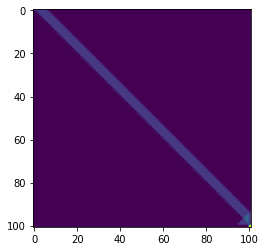

In [3]:
import numpy as np
import matplotlib.pyplot as plt

naive_transition = np.zeros((101, 101))
for i in range(100):
  #From condition 3 (dice)
  naive_transition[i,i+1:i+7] = 1/6
  #From condition 4 (bounce)
  naive_transition[i, 194 - i: 100] += 1/6

#From condition 2 (terminal)
naive_transition[100,100] = 1

#Visualize the matrix
plt.imshow(naive_transition)
plt.show()

Now, we incorporate snakes and ladders into the system. There are sevral ways to update the tranbsition matrix but a convenient way is to introduce another deterministic transition matrix that represents the instant move. In order to so, we create a dictionary pariing source to target as following:

In [4]:
snakes_ladders_dict = dict({1 : 38, 4 : 14, 9 : 31, 16 : 6, 21 : 42, 36 : 44, 47 : 26, 49 : 11, 51 : 67, 56 : 53, 62 : 19, 64 : 60, 71 : 91, 80 : 100, 93 : 73, 95 : 75, 98 : 78})

Next, we construct the instant transition matrix. Note that if there is no ladder or snake. The transition matrix will be an identity matrix.

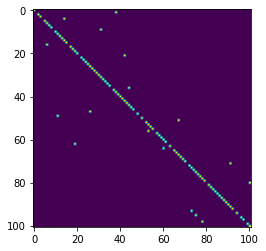

True

In [5]:
instant_transition = np.identity(101)
for i in snakes_ladders_dict.keys():
  instant_transition[i, i] = 0
  instant_transition[i, snakes_ladders_dict[i]] = 1

#Visualize the matrix
plt.imshow(instant_transition)
plt.show()

#As a sanity check, we know that instant_transition^2 should be the same as instant_transition
np.sum(instant_transition@instant_transition-instant_transition>0) == 0

Finally, we multiply the instant_transition matrix into the naive_transition.

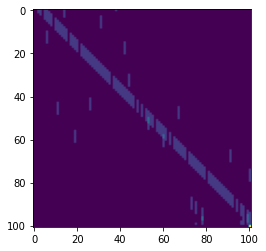

In [6]:
transition_matrix_101 = naive_transition @ instant_transition

#Visualize the matrix
plt.imshow(transition_matrix_101)
plt.show()

The next question is whether we can reduce the number of states to be more concise. In order to do so, we have to use the knowledge from the condition 1 (start). From the transition matrix, we can notice that the $i^\text{th}$ column will be $\textbf{0}$ for every $i$ being a key of snakes_ladders_dict. This suggests that these states cannot be reachable if the start is not in those states themselves. Since the start is in the zeroth state, those states cannot be visited at all. Thus, we can remove them from the state in the model.

In [7]:
print("The new model's size = ", 101-len(snakes_ladders_dict.keys()))

The new model's size =  84


##Constructing the transition dictionary and create a finite markov process item

Next, we will convert the (sparse) transition matrix into a dictionary form for this finite state markov process.

In [8]:
#Initialize transition_map
transition_map = dict()

#Iterate over non-termnial state
for source in range(100):
  if not source in snakes_ladders_dict.keys():
    conditional_transition = dict()
    for destination in np.where(transition_matrix_101[source] > 0)[0]:
      conditional_transition[destination] = transition_matrix_101[source][destination]
    transition_map[source] = Categorical(conditional_transition)

Afterwards, we can create the finite markov process

In [9]:
SnakesandLaddersMP = FiniteMarkovProcess(transition_map)

##Finding distribution of number of steps required to finsih the game

###Via sampling in the Finite Markov Process simulation (trace)

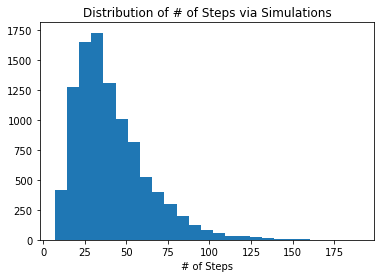

In [10]:
#Define start state
start_state = Categorical({NonTerminal(0):1.0})

#Create game traces
trace_game = SnakesandLaddersMP.traces(start_state)

#Sample
N = 10000
steps = []
for _ in range(N):
  sample = next(trace_game)
  step = -1
  for i in sample:
    step += 1
  steps.append(step)

plt.hist(steps, bins=25)
plt.title('Distribution of # of Steps via Simulations')
plt.xlabel('# of Steps')
plt.show()

Note that, since the sampling is a discrete sampling in the sense that we store the "sample" traces of the player on the board instead of the probability distribution of the location of the player, this method may requires several samples in order to be a good representative of the actual distribution of the number of steps required. (This is because of the high variance nature.)

###Via estimated cdf from matrix multiplication 

In this one, we store the probability that the player will be in each state as a row vector. We can find the probabbility that the player will be in the terminal state within time t, by looking at the value of the probability row vector at the last element.

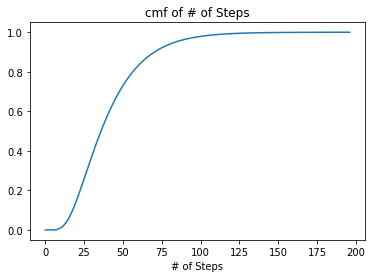

In [11]:
#Initilize the start state
state_vec = np.zeros(101)
state_vec[0] = 1

cdf = [0]
epsilon = 1e-4

while (1-state_vec[-1]) > epsilon:
  state_vec = state_vec @ transition_matrix_101
  cdf.append(state_vec[-1])

plt.plot(cdf)
plt.title('cmf of # of Steps')
plt.xlabel('# of Steps')
plt.show()

From cmf, we can find pmf. Note that this method yields smoother graph and less computation time (since we do not have to simulate multiple times).

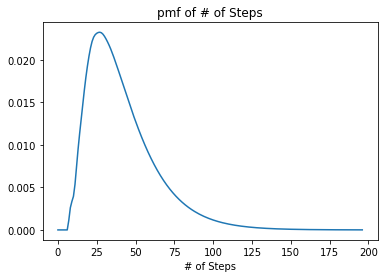

In [12]:
cdf_np = np.array(cdf)
pdf_np = cdf - np.append(0, cdf[:-1])

plt.plot(pdf_np)
plt.title('pmf of # of Steps')
plt.xlabel('# of Steps')
plt.show()

##Adding Reward

Similar, to what we have done for markov process earlier, we will create another map including the reward. Since we want to find the expected number of moves required for the game to be terminated. We can do so by counting each non-terminal state we passed equally. In this case, we will set the reward for landing on any non-terminal state to be 1. If we set the $\gamma$ to be 1, the expected reward will be the expected number of moves required to finish the game.

In [13]:
#Initialize transition_map
transition_reward_map = dict()

#Iterate over non-termnial state
for source in range(100):
  if not source in snakes_ladders_dict.keys():
    conditional_transition = dict()
    for destination in np.where(transition_matrix_101[source] > 0)[0]:
      #The code is essentially the same as when we create a mapping for MP.
      #Notice that we just replace destination with (destination,1)
      conditional_transition[(destination, 1)] = transition_matrix_101[source][destination]
    transition_reward_map[source] = Categorical(conditional_transition)

In [14]:
SnakesandLaddersMRP = FiniteMarkovRewardProcess(transition_reward_map)
print('Expected # of Moves:', SnakesandLaddersMRP.get_value_function_vec(gamma=1)[0])

Expected # of Moves: 41.25159602937847


##Expected # of Moves

In [15]:
print('Expected # of Moves via MP simulations:', np.mean(steps))
print('Expected # of Moves via matirx multiplication:', np.sum((pdf_np)*np.arange(np.size(pdf_np))))
print('Expected # of Moves via MRP:', SnakesandLaddersMRP.get_value_function_vec(gamma=1)[0])

Expected # of Moves via MP simulations: 40.9019
Expected # of Moves via matirx multiplication: 41.23103222316583
Expected # of Moves via MRP: 41.25159602937847


#2. Frog Puzzle

##10 Steps Case

There are 11 positions (indexed as 0 to 10). The rules of the game is the following:
1. Start at 0 (Start Distribution)
2. End at 10 (Terminal state)
3. At state $i$, the frog will jump to every state $j$ uniformly at random for all $j>i$. The frog cannot jump back or remain at the same place. (Transition rule)

Thus, the transition matrix can be modelled as

\begin{align*}
\text{transition_matrix} = 
\begin{bmatrix}
0 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10 & 1/10\\
0 & 0 & 1/9 & 1/9 & 1/9 & 1/9 & 1/9 & 1/9 & 1/9 & 1/9 & 1/9\\
0 & 0 & 0 & 1/8 & 1/8 & 1/8 & 1/8 & 1/8 & 1/8 & 1/8 & 1/8\\
0 & 0 & 0 & 0 & 1/7 & 1/7 & 1/7 & 1/7 & 1/7 & 1/7 & 1/7\\
0 & 0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 0 & 0 & 1/5 & 1/5 & 1/5 & 1/5 & 1/5\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1/4 & 1/4 & 1/4 & 1/4\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1/3 & 1/3 & 1/3\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1/2 & 1/2\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}
\end{align*}

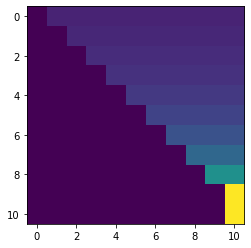

In [16]:
transition_matrix = np.zeros((11,11))

#conditon 2
transition_matrix[10,10] = 1

#condition 3
for i in range(10):
  transition_matrix[i, i+1:] = 1/(10-i)

#Visualize the matrix
plt.imshow(transition_matrix)
plt.show()

We will use MRP method

In [17]:
#Initialize transition_map
transition_reward_map = dict()

#Iterate over non-termnial state
for source in range(10):
  conditional_transition = dict()
  for destination in np.where(transition_matrix[source] > 0)[0]:
    conditional_transition[(destination, 1)] = transition_matrix[source][destination]
  transition_reward_map[source] = Categorical(conditional_transition)

FrogMRP = FiniteMarkovRewardProcess(transition_reward_map)
print('Expected # of Moves:', FrogMRP.get_value_function_vec(gamma=1)[0])

Expected # of Moves: 2.9289682539682547


##General n-step case

In this case, we may not be able to easily solve by constructing MRP class first. However, we can do so by induction argument. Before looking at the induction, which will confirm the result, we first have to think about what will the answer should be first.

In this case, let $f(n)$ represents the expected number of moves away from reaching the destination when the current state is $n$ step away.

Therefore, it is obvious that $f(0)=0$ and $f(1)=1$.
For an arbitary positive integer $i > 1$, 

\begin{align*}
  f(i) &= 1 + \frac{1}{i}\Sigma_{j=0}^{i-1} {f(j)}\\
  &= 1 + \frac{1}{i}\Sigma_{j=1}^{i-1} {f(j)}\\
  &= 1 + \frac{1}{i} + \frac{1}{i}\Sigma_{j=1}^{i-2} {f(j)} + \frac{1}{i(i-1)} \Sigma_{j=1}^{i-2} {f(j)}\\
  &= 1 + \frac{1}{i} + \frac{1}{i-1}\Sigma_{j=1}^{i-2} {f(j)}
\end{align*}

This suggests that $f(i) = \Sigma_{j=1}^{i} \frac{1}{j}$ may work. 


Next, we will show by induction that the function $f$ will satisfy $f(0)=0$ and $f(i) = \Sigma_{j=1}^{i} \frac{1}{j}$ .

Base Case:

If the current state is 0 steps away from the destination, the expected number of moves is 0. Thus, $f(0)=0$.

If the current state is 1 steps away from the destination, the expected number of moves is 1. Thus, $f(1)=1$.

Inductive Case: Let $f(i) = \Sigma_{j=1}^{i} \frac{1}{j}$ for all $i<n$. We will show that $f(n) = \Sigma_{j=1}^{n} \frac{1}{j}$.

\begin{align*}
  f(n) &= 1 + \frac{1}{n}\Sigma_{i=0}^{n-1} {f(i)}\\
  &= 1 + \frac{1}{n}\Sigma_{i=1}^{n-1} {f(i)}\\
  &= 1 + \frac{1}{n}\Sigma_{i=1}^{n-1} \Sigma_{j=1}^{i} \frac{1}{j}\\
  &= 1 + \frac{1}{n}\Sigma_{j=1}^{n-1}  \frac{n-j}{j}\\
  &= 1 + \Sigma_{j=1}^{n-1}  \frac{1}{j} - \frac{n-1}{n}\\
  &= \Sigma_{j=1}^{n}  \frac{1}{j}
\end{align*}

Thus, if starts at 0, in expectation, it will take $\Sigma_{i=1}^{n}  \frac{1}{i}$ steps to reach the destination. Note that this scales with $ln(n)$.




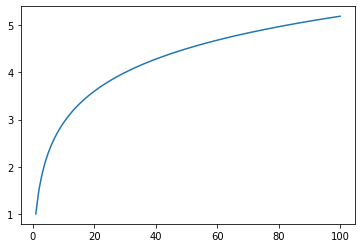

In [18]:
plt.plot(np.arange(1,101), np.cumsum(np.ones(100) / np.arange(1,101)))
plt.show()

#3. Tennis Game

Let the game be a formal game such that
1. There are 2 players, A and B.
2. In each timestep, A moves (wins a score) with probability $p$, and B moves otherwise.

## First-to-get-n wins

Using MP with the encoding of the state as (A_score, B_score) is possible. However, it may be hard to do so. Thus, we use the fact that first-to-get-n wins is equivalent to person-to-get-the-majority-score-from-(2n-1) wins.

Thus, we will get that the probability that A wins is
\begin{align*}
  P_A &= ∑_{i=n}^{2n-1} {{2n-1}\choose i}p^i (1-p)^{2n-1-i}
\end{align*}

In [19]:
def P_firsttogetnwins(p, n):
  Prob = 0
  prob = p**(2*n-1)
  for i in range(n):
    Prob += prob
    prob *= (1-p)*(2*n-i-1)/p/(i+1)
  return Prob

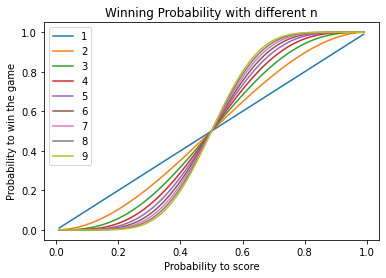

In [20]:
p_array = np.arange(1,100)/100
for n in range(1,10):
  P = []
  for p in p_array:
    P.append(P_firsttogetnwins(p, n))
  plt.plot(p_array, P, label=str(n))
plt.legend()
plt.ylabel('Probability to win the game')
plt.xlabel('Probability to score')
plt.title('Winning Probability with different n')
plt.show()

##First-to-score-n-more wins

One well known charactersitics of tennis scoring system is that for A to win, A has to score 2 more than B even after getting 3 points (40 in tennis). This system will have Game(A)-Advantage(A)-Deuce-Advantage(B)-Game(B).

Before diving into the tennis scoring system, we can think about an MP with $2n+1$ states, denoted as $-n, -(n-1), \dots, -1, 0, 1, 2, \dots n$. The state $-n$ and the state $n$ are terminal states. For simplicity (with the 0-iundexing of matrix), we shift the index to be from $0$ to $2n$. Thus, the state $0$ and the state $2n$ are terminal states.

\begin{align*}
\text{transition_matrix} = 
\begin{bmatrix}
1 & 0 & 0 & 0 & … & 0 & 0 & 0\\
p & 0 & 1-p & 0 & … & 0 & 0 & 0\\
0 & p & 0 & 1-p & … & 0 & 0 & 0\\
0 & 0 & p & 0  & … & 0 & 0 & 0\\
0 & 0 & 0 & p  & … & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots &  & \vdots & \vdots& \vdots\\
0 & 0 & 0 & 0  & … & 0 & 1-p & 0\\
0 & 0 & 0 & 0  & … & p & 0 & 1-p\\
0 & 0 & 0 & 0  & … & 0 & 0 & 1\\
\end{bmatrix}
\end{align*}

To calculate the winning probability (analytically), let $v$ represent winning probability at each position (excluding state $0$ and $2n$). We then see that

\begin{align*}
v = 
\begin{bmatrix}
0 & 1-p & 0 & … & 0 & 0\\
p & 0 & 1-p & … & 0 & 0\\
0 & p & 0  & … & 0 & 0\\
0 & 0 & p  & … & 0 & 0\\
\vdots & \vdots & \vdots &  & \vdots & \vdots\\
0 & 0 & 0  & … & 0 & 1-p\\
0 & 0 & 0  & … & p & 0\\
\end{bmatrix}
v
+
\begin{bmatrix}
p\\
0\\
0\\
0\\
\vdots\\
0\\
0\\
\end{bmatrix}
\end{align*}

Thus, 
\begin{align*}
\begin{bmatrix}
-1 & 1-p & 0 & … & 0 & 0\\
p & -1 & 1-p & … & 0 & 0\\
0 & p & -1  & … & 0 & 0\\
0 & 0 & p  & … & 0 & 0\\
\vdots & \vdots & \vdots &  & \vdots & \vdots\\
0 & 0 & 0  & … & -1 & 1-p\\
0 & 0 & 0  & … & p & -1\\
\end{bmatrix}
v
=
\begin{bmatrix}
-p\\
0\\
0\\
0\\
\vdots\\
0\\
0\\
\end{bmatrix}
\end{align*}

And we can solve this linear equation.

Another similar method is the following:

\begin{align*}
  v_n &= pv_{n-1} + (1-p)v_{n+1}\\
  &= p(pv_{n-2}+(1-p)v_n) + (1-p)(pv_{n}+(1-p)v_{n+2})\\
  (p^2 + (1-p)^2)v_n &= p^2v_{n-2} + (1-p)^2v_{n+2}
\end{align*}

Similary, we will get that $v_n = \frac{p^n}{p^n + (1-p)^n}$.

In [21]:
def P_firsttoscorenmorewins(p, n):
  return p**n/(p**n+(1-p)**n)

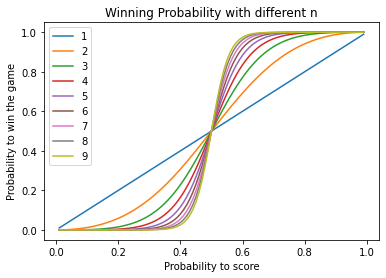

In [22]:
p_array = np.arange(1,100)/100
for n in range(1,10):
  P = []
  for p in p_array:
    P.append(P_firsttoscorenmorewins(p, n))
  plt.plot(p_array, P, label=str(n))
plt.legend()
plt.ylabel('Probability to win the game')
plt.xlabel('Probability to score')
plt.title('Winning Probability with different n')
plt.show()

##0-15-30-40-Deuce-Advantage-Game

We define state as (score_A, score_B). Thus, the states possible will be the following:

*   (0, 0) (Start)
*   (0, 1)
*   (0, 2)
*   (0, 3)
*   (0, 4) (Terminal)
*   (1, 0)
*   (1, 1)
*   (1, 2)
*   (1, 3)
*   (1, 4) (Terminal)
*   (2, 0)
*   (2, 1)
*   (2, 2)
*   (2, 3)
*   (2, 4) (Terminal)
*   (3, 0)
*   (3, 1)
*   (3, 2)
*   (3, 3)
*   (3, 4)
*   (3, 5) (Terminal)
*   (4, 0) (Terminal)
*   (4, 1) (Terminal)
*   (4, 2) (Terminal)
*   (4, 3) 
*   (5, 3) (Terminal)

Note that (4, 4) can be reduced to (3, 3), (8, 6) can be reduced to (5, 3), and so forth.

However, let define a more general class, in which the states will be determined by $m$, $n$ such that $1\le n\le m$ following the winning condition: score_A $\ge m + 1$ and score_A $\ge n + $ score_B 

We will see that score_A and score_B can increase to avery large value, which will create difficulty in modelling. However, we can collpase some states together (similar to the idea of having deuce).

In this case, we will let the (possible) state to be (score_A, score_B) for all $0 \le$ score_A, score_B $\le m$

In this case, the state will be
1.   (score_A, score_B) for all $0 \le$ score_A, score_B $\le m+n+1$

Note that some state will not be reachable.

The transition will be
1.   \{(score_A$+1$, score_B):p, (score_A, score_B$+1$):1-p\} if score_A, score_B $\le m$
2.   \{(m, score_B-1):p, (m, score_B$+1$):1-p\} if score_B$>m$
3.   \{(score_A+1, $m$):p, (score_A-1, $m$):1-p\} if score_A$>m$

In [23]:
class TennisGame(FiniteMarkovRewardProcess):
  def __init__(self, m=3, n=2, p=0.5):
    self.m = m
    self.n = n
    self.p = p
    super().__init__(self.get_transition_reward_map())

  def get_transition_reward_map(self):
    #Initialize transition_map
    transition_reward_map = dict()

    #Iterate over non-termnial state
    for score_A in range(self.m+self.n+1):
      for score_B in range(self.m+self.n++1):
        #if not a terminal state
        if (score_A >= self.m+1)+(score_A >= self.n + score_B)+(score_B >= self.m+1)+(score_B >= self.n + score_A) <=1:
          conditional_transition = dict()
          if (score_A <= self.m)*(score_B <= self.m):
            conditional_transition[((score_A+1,score_B), int((score_A >= self.m)*(score_A >= self.n + score_B - 1)))] = self.p
            conditional_transition[((score_A,score_B+1), 0)] = 1-self.p
          elif (score_A == self.m):
            conditional_transition[((score_A, score_B-1), 0)] = self.p
            conditional_transition[((score_A, score_B+1), 0)] = 1-self.p
          else:
            conditional_transition[((score_A+1, score_B), int((score_A >= self.m)*(score_A >= self.n + score_B - 1)))] = self.p
            conditional_transition[((score_A-1, score_B), 0)] = 1-self.p
          transition_reward_map[(score_A, score_B)] = Categorical(conditional_transition)

    return transition_reward_map

In [24]:
TennisMRP = TennisGame(m=3, n=2, p=0.55)
print('Winning Probability:', TennisMRP.get_value_function_vec(gamma=1)[0])

Winning Probability: 0.6231485024752477


###Winning probability via constructing MRP

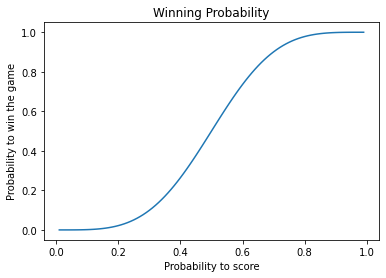

In [25]:
p_array = np.arange(1,100)/100
P = []
for p in p_array:
  TennisMRP = TennisGame(m=3, n=2, p=p)
  P.append(TennisMRP.get_value_function_vec(gamma=1)[0])
plt.plot(p_array, P)
plt.ylabel('Probability to win the game')
plt.xlabel('Probability to score')
plt.title('Winning Probability')
plt.show()

###Via calculation

We can think of letting the game being played for 6 steps first. Thus, the 

The winning probabilty of A is 
\begin{align*}
  P_A &= {6\choose0}p^6+{6\choose1}p^5(1-p)+{6\choose2}p^4(1-p)^2+{6\choose3}p^3(1-p)^3\frac{p^2}{p^2+(1-p)^2}\\
  &= 10p^6-24p^5+15p^4+20p^3(1-p)^3\frac{p^2}{p^2+(1-p)^2}
\end{align*}


In [26]:
def P_tennis(p):
  return (15*p**4)-(24*p**5)+(10*p**6) + 20*(p**5)*(1-p)**3/(p**2+(1-p)**2)

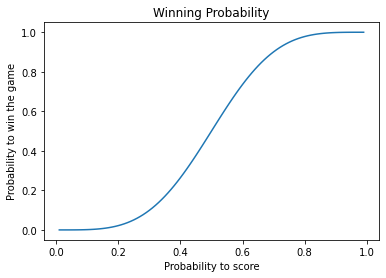

In [27]:
p_array = np.arange(1,100)/100
P=[]
for p in p_array:
  P.append(P_tennis(p))
plt.plot(p_array, P)
plt.ylabel('Probability to win the game')
plt.xlabel('Probability to score')
plt.title('Winning Probability')
plt.show()

# 4. Stock Price

Consider a GBM

In [115]:
@dataclass(frozen=True)
class PriceState:
    price: float

class StockMRP(MarkovRewardProcess[PriceState]):

    def __init__(self, mu: float, sigma: float, f:[[float, float], float]):
        self.mu: float = mu
        self.sigma: float = sigma
        self.f:[[float, float], float] = f

    def transition_reward(self, state: NonTerminal[PriceState]) -> SampledDistribution[Tuple[State[PriceState], float]]:
        def sample_next_state_reward(state=state) -> Tuple[State[PriceState], float]:
            new_price: float = state.state.price * np.exp(np.random.normal(self.mu, self.sigma))
            next_state: PriceState = PriceState(new_price)
            reward: float = f(state.state.price, new_price)
            return NonTerminal(next_state), reward

        return SampledDistribution(sample_next_state_reward)

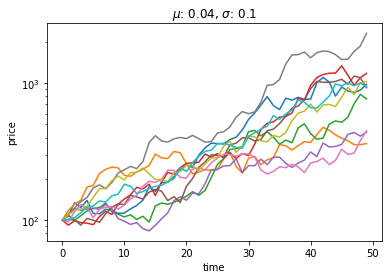

In [141]:
def f(a: float, b: float):
  return np.abs(a-b)

mu = 0.04
sigma = 0.1

GBM = StockMRP(mu, sigma, f)
Traces = GBM.reward_traces(start_state_distribution = Constant(NonTerminal(PriceState(100.0))))


for _ in range(10):
  Trace = next(Traces)
  prices = []
  for _ in range(50):
    price_state = next(Trace)
    prices.append(price_state.state.state.price)
  plt.plot(prices)
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('price')
plt.title('$\mu$: ' + str(mu) + ", $\sigma$: " + str(sigma))
plt.show()
